In [ ]:
!pip install vit_keras
!pip install tensorflow==2.12 tensorflow-addons[tensorflow]

#basic
import pandas as pd
import numpy as np

#sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#tensorflow
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.models import Sequential

#System
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Katherine's path
# os.chdir('/content/drive/MyDrive/DSO569/DSO 569 Final Project and Presentation/Data')

# manhui's path
os.chdir('/content/drive/MyDrive/DSO 569 Final Project and Presentation/Data')

# Wenyi's path
# os.chdir('/content/drive/MyDrive/DSO 569 Final Project and Presentation/Data')

## Data Preprocessing

In [ ]:
# Read csv file
label_df = pd.read_csv("./labels.csv")
# Train data shape
print(f"Train dataset shape: {label_df.shape}")
# Sample of the train_data DataFrame
label_df.head()

Train dataset shape: (10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


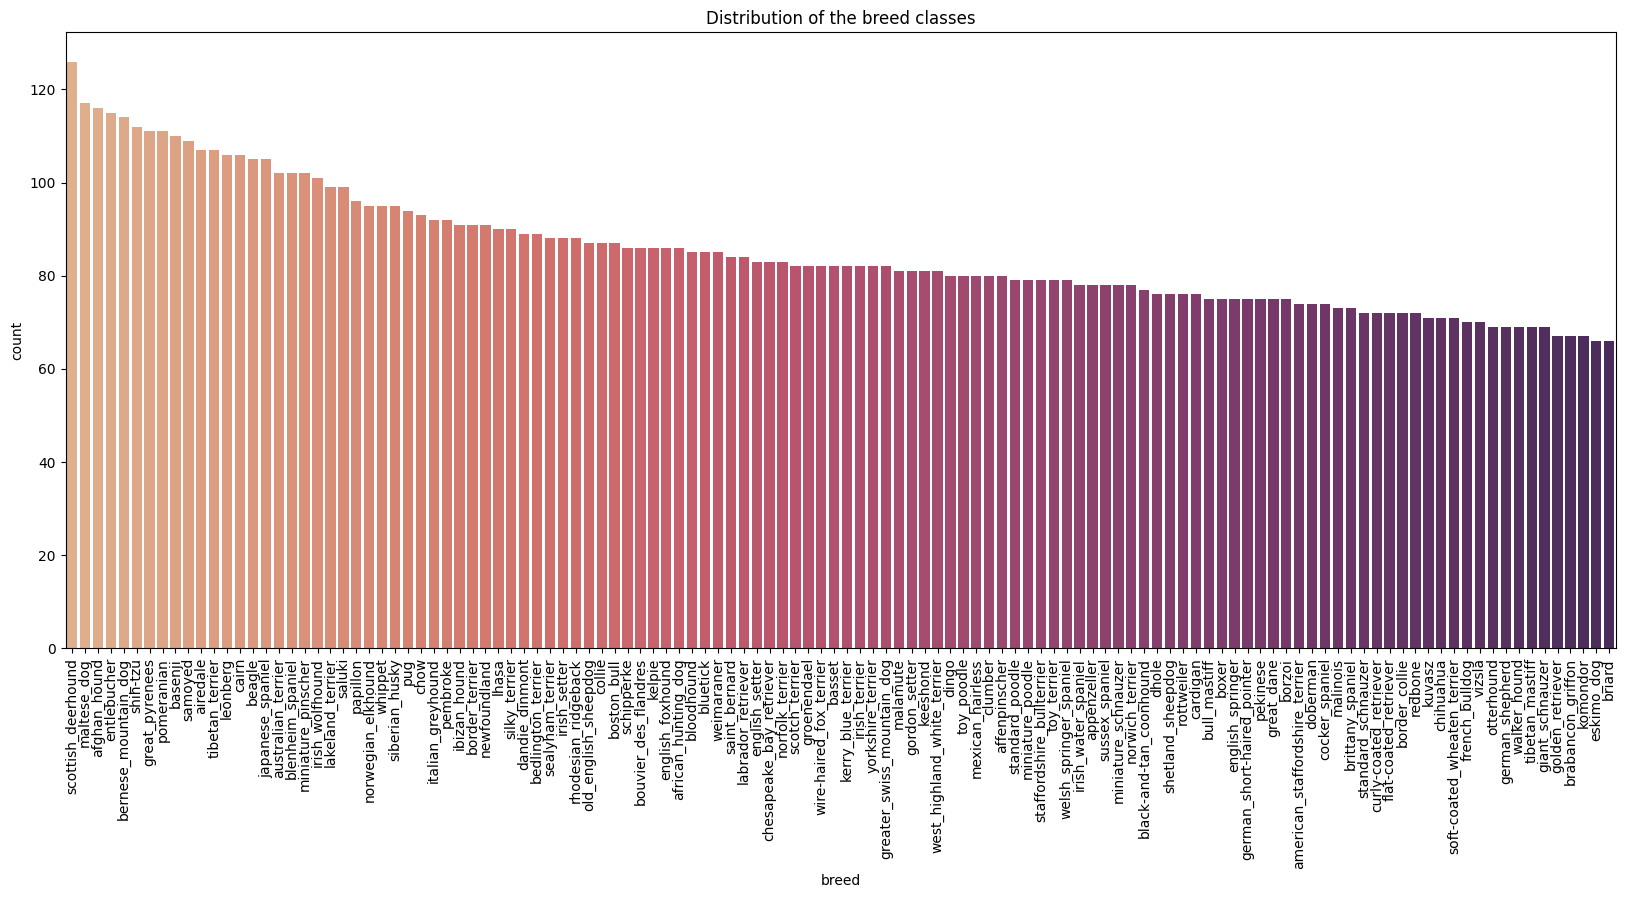

In [ ]:
breed_classes = label_df.breed.value_counts().reset_index()
plt.figure(figsize=(20,8))
sns.barplot(breed_classes, x='breed', y='count', palette="flare")
plt.xticks(rotation=90)
plt.title("Distribution of the breed classes")
plt.show()

### Label Encoding

In [ ]:
# Encode the 'breed' column to numeric values

le = LabelEncoder()
label_df['encoded_label'] = le.fit_transform(label_df.loc[:,'breed'])

# Add full file paths for image loading
label_df['file_path'] = './train/' + label_df['id'] + '.jpg'

In [ ]:
label_df.head()

,id,breed,encoded_label,file_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19,./train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37,./train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,85,./train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15,./train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49,./train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
label_df.shape

(10222, 4)

In [ ]:
label_df['encoded_label'].nunique()

120

In [ ]:
# Define a function to load and preprocess the image
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    return image, label

# Define the file paths and labels
file_paths = label_df['file_path'].values
labels = label_df['encoded_label'].values

#Train_validation_test_split (70/20/10)
#two stage split:
# 1st:(train & validate)/test:0.9/0.1
# 2nd: train & validate:0.77778/0.22222=(0.7/0.9)/(0.2/0.9)
train_validate_files, test_files, train_validate_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.1, random_state=42, stratify = labels)
train_files, validate_files, train_labels, validate_labels = train_test_split(
    train_validate_files, train_validate_labels, test_size=0.2222, random_state=42,
    stratify = train_validate_labels)

# Create TensorFlow datasets for train and test sets
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image)

validate_dataset = tf.data.Dataset.from_tensor_slices((validate_files, validate_labels))
validate_dataset = validate_dataset.map(load_and_preprocess_image)

test_dataset = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image)

In [ ]:
element_spec = train_dataset.element_spec

# Print the element_spec
print("Element spec:")
print(element_spec)

#data has various shape

# Example to iterate through the dataset
for image, label in train_dataset.take(10):
    print(image.numpy().shape, label)

Element spec:
(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(450, 380, 3) tf.Tensor(108, shape=(), dtype=int64)
(500, 333, 3) tf.Tensor(71, shape=(), dtype=int64)
(500, 375, 3) tf.Tensor(29, shape=(), dtype=int64)
(269, 150, 3) tf.Tensor(113, shape=(), dtype=int64)
(411, 300, 3) tf.Tensor(69, shape=(), dtype=int64)
(250, 300, 3) tf.Tensor(81, shape=(), dtype=int64)
(347, 400, 3) tf.Tensor(81, shape=(), dtype=int64)
(499, 500, 3) tf.Tensor(82, shape=(), dtype=int64)
(375, 500, 3) tf.Tensor(14, shape=(), dtype=int64)
(400, 500, 3) tf.Tensor(75, shape=(), dtype=int64)


### Visualize the data

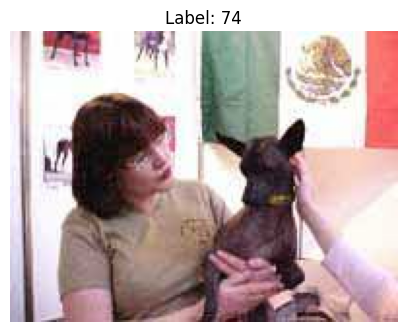

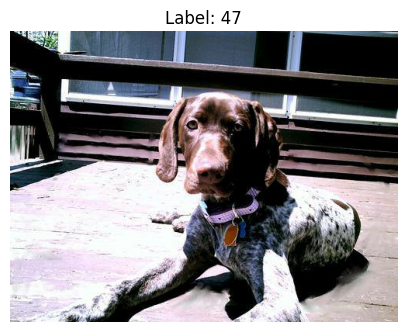

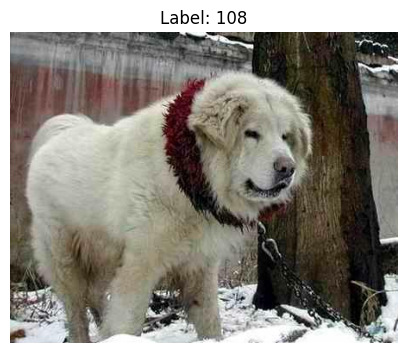

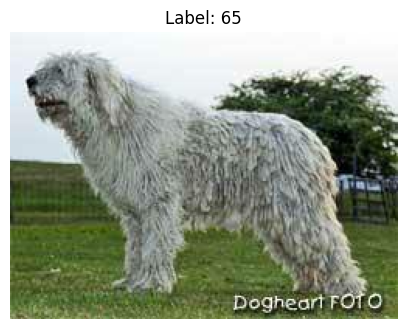

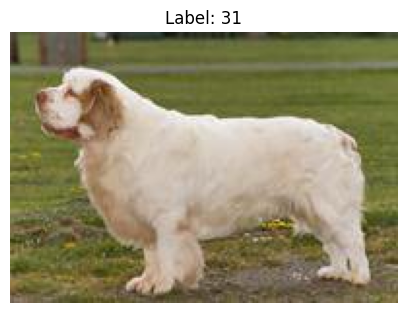

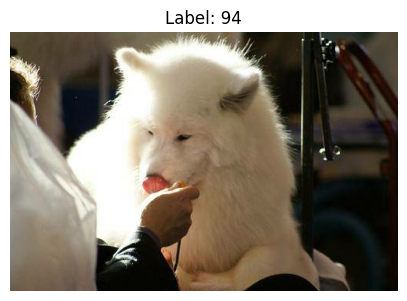

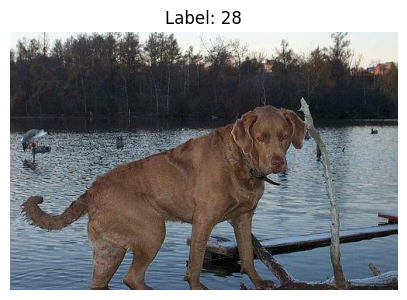

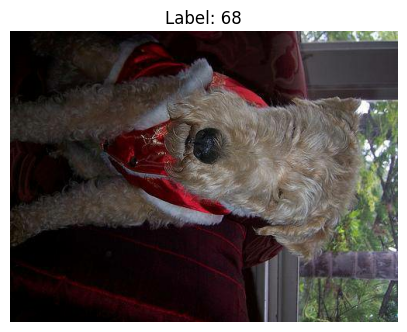

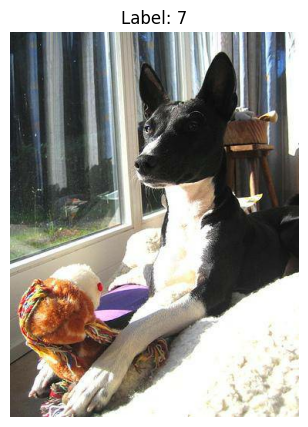

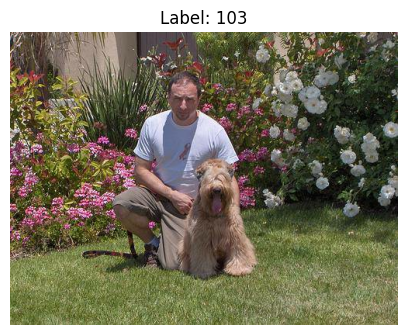

In [ ]:
# check if image properly loaded
# for image, label in train_dataset.take(10):
# for image, label in test_dataset.take(10):
for image, label in validate_dataset.take(10):  # Take the first 10 elements from the dataset
    plt.figure(figsize=(5, 5))
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
    plt.show()

### Resize Dats

In [ ]:
# Print the element_spec
print("Element spec:")
print(train_dataset.element_spec)

Element spec:
(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [ ]:
# #resize as needed
def preprocess_image_ag(image):
    # Resize the image to the desired input size
    image = tf.image.resize(image, (224, 224))

    # data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Normalize image to [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.convert_image_dtype(image, tf.float32)
    # image = tf.keras.applications.resnet.preprocess_input(image)

    return image

def preprocess_image_test_val(image):
    # Resize the image to the desired input size
    image = tf.image.resize(image, (224, 224))

    # Normalize image to [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.convert_image_dtype(image, tf.float32)
    # image = tf.keras.applications.resnet.preprocess_input(image)

    return image

# # Apply the preprocessing function to your dataset
# #this does not change the base dataframe, which reserve image form for other models
train_vit_dataset = train_dataset.map(lambda image, label: (preprocess_image_ag(image), label))
test_vit_dataset = test_dataset.map(lambda image, label: (preprocess_image_test_val(image), label))
validate_vit_dataset = validate_dataset.map(lambda image, label: (preprocess_image_test_val(image), label))

# Batch the dataset
batch_size = 128

train_vit_dataset = train_vit_dataset.shuffle(7500)
train_vit_dataset = train_vit_dataset.batch(batch_size)
train_vit_dataset = train_vit_dataset.prefetch(tf.data.AUTOTUNE)

test_vit_dataset = test_vit_dataset.batch(batch_size)
test_vit_dataset = test_vit_dataset.prefetch(tf.data.AUTOTUNE)

validate_vit_dataset = validate_vit_dataset.batch(batch_size)
validate_vit_dataset = validate_vit_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
#Use this to check batch size, it accidentally batch before, need to unbatch before rebatch
#if batched: (TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32, name=None)
#if not batched: (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)

print(train_vit_dataset.element_spec)
print(test_vit_dataset.element_spec)
print(validate_vit_dataset.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


# Pre-trained ViT Model

In [ ]:
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.12.0


In [ ]:
import numpy as np
import pandas as pd
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
from tensorflow.keras import Model, callbacks
import glob, random, os, warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
input_shape = (224, 224, 3)
image_size = 224
n_classes = 120

In [ ]:
from vit_keras import vit

vit_model = vit.vit_b32(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = n_classes)

353253686/353253686 [==============================] - 2s 0us/step


In [ ]:
for layer in vit_model.layers:
  layer.trainable = False

## ViT Model Architecture

In [ ]:
vit = tf.keras.Sequential([
        # tf.keras.layers.Input(shape = input_shape),
        # data_augmentation,
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation = tfa.activations.gelu),
        layers.Dropout(0.2),
        tf.keras.layers.Dense(120, 'softmax')
    ],
    name = 'vision_transformer')

# vit.build(input_shape)
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               393728    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 256)        

## Train the Model

In [ ]:
warnings.filterwarnings("ignore")

learning_rate = 0.001

optimizer = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)

vit.compile(optimizer = optimizer,
              # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
early_stopping_callback = callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=5,
                                                  restore_best_weights=True)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint('../Keras_model/vit_model.keras',
                                                      monitor='val_accuracy',
                                                      save_best_only=True)

In [ ]:
vit_history = vit.fit(train_vit_dataset,
          validation_data = validate_vit_dataset,
          epochs = 50,
          batch_size = 128,
          callbacks=[early_stopping_callback, model_checkpoint])

Epoch 1/50
56/56 [==============================] - 425s 4s/step - loss: 5.1314 - accuracy: 0.0140 - val_loss: 4.4221 - val_accuracy: 0.0802
Epoch 2/50
56/56 [==============================] - 211s 4s/step - loss: 4.4760 - accuracy: 0.0746 - val_loss: 3.2776 - val_accuracy: 0.3804
Epoch 3/50
56/56 [==============================] - 212s 4s/step - loss: 3.7735 - accuracy: 0.1855 - val_loss: 2.1431 - val_accuracy: 0.5384
Epoch 4/50
56/56 [==============================] - 210s 4s/step - loss: 3.2746 - accuracy: 0.2517 - val_loss: 1.5476 - val_accuracy: 0.6073
Epoch 5/50
56/56 [==============================] - 211s 4s/step - loss: 2.9521 - accuracy: 0.3007 - val_loss: 1.3066 - val_accuracy: 0.6357
Epoch 6/50
56/56 [==============================] - 210s 4s/step - loss: 2.7052 - accuracy: 0.3387 - val_loss: 1.1890 - val_accuracy: 0.6738
Epoch 7/50
56/56 [==============================] - 209s 3s/step - loss: 2.4833 - accuracy: 0.3864 - val_loss: 1.1368 - val_accuracy: 0.6778
Epoch 8/50
56

In [ ]:
# Maximum validation accuracy
max(vit_history.history['val_accuracy'])

0.7105134725570679

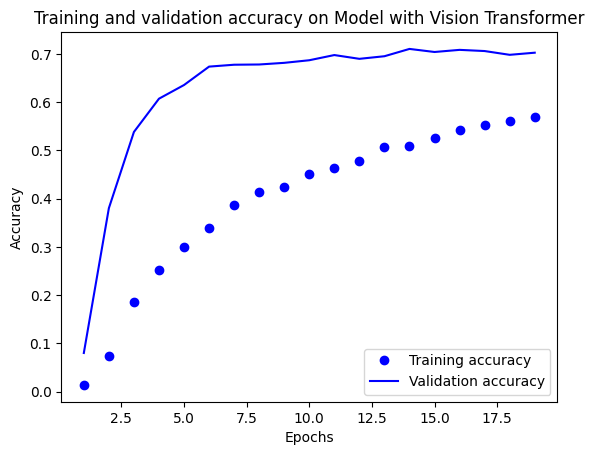

In [ ]:
vit_history_dict = vit_history.history
accuracy = vit_history_dict["accuracy"]
val_accuracy = vit_history_dict["val_accuracy"]
epochs = range(1, len(val_accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy on Model with Vision Transformer")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# evaluate the mode
vit.load_weights("../Keras_model/vit_model.keras")
vit.evaluate(test_vit_dataset)

8/8 [==============================] - 28s 4s/step - loss: 1.0445 - accuracy: 0.7028


[1.044475793838501, 0.7028347849845886]